In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

import nltk

In [52]:
df = pd.read_csv('../data/subreddit_data.csv')
df.head(3)

,subreddit,title,selftext,score,num_comments,created_utc,total_text,title_length,selftext_length,title_word_count,selftext_word_count
0,0,Careers with a BS in Mechanical Engineering,1,60,210,1638995117,careers with a bs in mechanical engineering hi...,43,726,7,132
1,0,Am I really an engineer?,1,19,59,1638988318,am i really an engineer? let me first explain ...,24,2129,5,362
2,0,How do lighthouses withstand being constantly ...,1,17,20,1638986902,how do lighthouses withstand being constantly ...,85,411,13,46


In [53]:
df.dtypes

subreddit               int64
title                  object
selftext                int64
score                   int64
num_comments            int64
created_utc             int64
total_text             object
title_length            int64
selftext_length         int64
title_word_count        int64
selftext_word_count     int64
dtype: object

In [54]:
df.isnull().sum()

subreddit              0
title                  0
selftext               0
score                  0
num_comments           0
created_utc            0
total_text             0
title_length           0
selftext_length        0
title_word_count       0
selftext_word_count    0
dtype: int64

In [55]:
#Baseline which will obviously be 50% on the dot
df['subreddit'].value_counts(normalize = True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

# EDA 

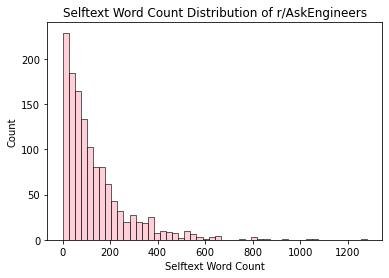

In [92]:
#Make histograms to compare word count and length distributions from both reddits
# r/AskEngineers
sns.histplot(df[df['subreddit'] ==0]['selftext_word_count'], color = 'pink');
plt.xlabel('Selftext Word Count')
plt.ylabel('Count')
plt.title('Selftext Word Count Distribution of r/AskEngineers')
plt.savefig('../visualizations/selftext_wordcount_distrib.png', dpi = 200, bbox_inches = 'tight')

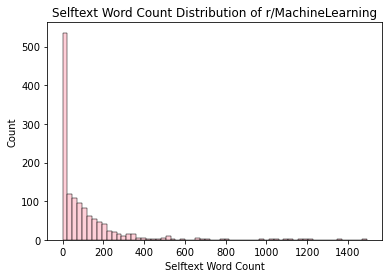

In [93]:
# r/MachineLearning
sns.histplot(df[df['subreddit'] ==1]['selftext_word_count'], color = 'pink');
plt.xlabel('Selftext Word Count')
plt.ylabel('Count')
plt.title('Selftext Word Count Distribution of r/MachineLearning')
plt.savefig('../visualizations/ml_selftext_wordcount_distrib.png', dpi = 200, bbox_inches = 'tight')

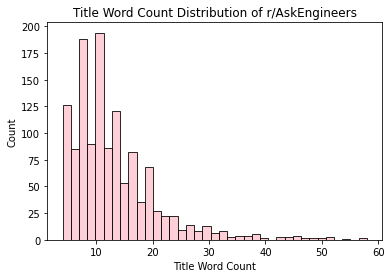

In [94]:
#Now for title word count
# r/AskEngineers
sns.histplot(df[df['subreddit'] ==0]['title_word_count'], color = 'pink');
plt.xlabel('Title Word Count')
plt.ylabel('Count')
plt.title('Title Word Count Distribution of r/AskEngineers')
plt.savefig('../visualizations/ae_title_wordcount_distrib.png', dpi = 200, bbox_inches = 'tight')

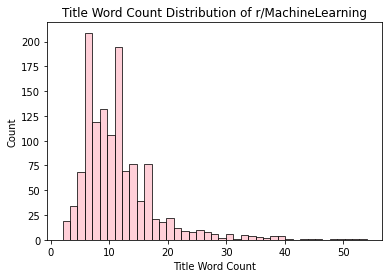

In [95]:
# r/MachineLearning
sns.histplot(df[df['subreddit'] ==1]['title_word_count'], color = 'pink');
plt.xlabel('Title Word Count')
plt.ylabel('Count')
plt.title('Title Word Count Distribution of r/MachineLearning')
plt.savefig('../visualizations/ml_title_wordcount_distrib.png', dpi = 200, bbox_inches = 'tight')

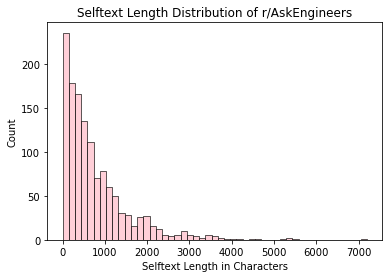

In [96]:
#Now for selftext length 
# r/AskEngineers
sns.histplot(df[df['subreddit'] ==0]['selftext_length'], color = 'pink');
plt.xlabel('Selftext Length in Characters')
plt.ylabel('Count')
plt.title('Selftext Length Distribution of r/AskEngineers')
plt.savefig('../visualizations/ae_selftext_length_distrib.png', dpi = 200, bbox_inches = 'tight')

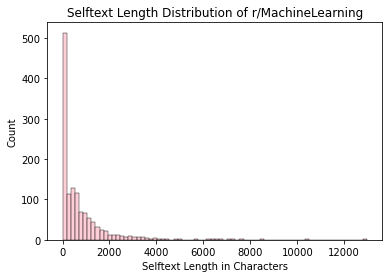

In [97]:
# r/MachineLearning
sns.histplot(df[df['subreddit'] ==1]['selftext_length'], color = 'pink');
plt.xlabel('Selftext Length in Characters')
plt.ylabel('Count')
plt.title('Selftext Length Distribution of r/MachineLearning')
plt.savefig('../visualizations/ml_selftext_length_distrib.png', dpi = 200, bbox_inches = 'tight')

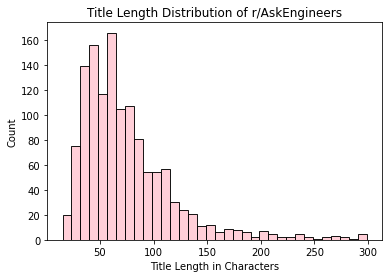

In [98]:
#Now for title length 
# r/AskEngineers
sns.histplot(df[df['subreddit'] ==0]['title_length'], color = 'pink');
plt.xlabel('Title Length in Characters')
plt.ylabel('Count')
plt.title('Title Length Distribution of r/AskEngineers')
plt.savefig('../visualizations/ae_title_length_distrib.png', dpi = 200, bbox_inches = 'tight')

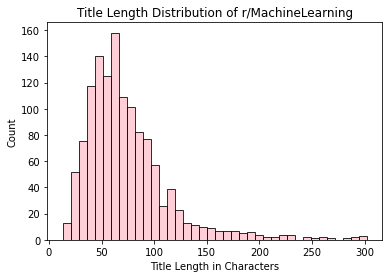

In [99]:
# r/MachineLearning
sns.histplot(df[df['subreddit'] ==1]['title_length'], color = 'pink');
plt.xlabel('Title Length in Characters')
plt.ylabel('Count')
plt.title('Title Length Distribution of r/MachineLearning')
plt.savefig('../visualizations/ml_title_length_distrib.png', dpi = 200, bbox_inches = 'tight')

,selftext
subreddit,
0,0.895914
1,0.653045


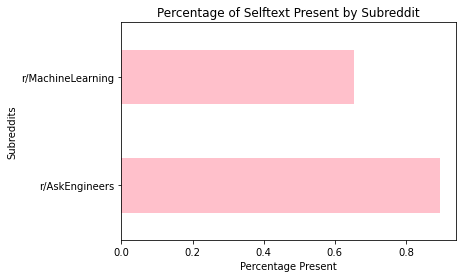

In [100]:
#I want to make a comparison plot of the probability of selftext
plot = df.groupby('subreddit')[['selftext']].mean()
plot.plot(kind = 'barh', legend = None, color = 'pink')
plt.yticks([0,1],['r/AskEngineers','r/MachineLearning'])
plt.ylabel('Subreddits')
plt.xlabel('Percentage Present')
plt.title('Percentage of Selftext Present by Subreddit')
plt.savefig('../visualizations/selftext_probs.png', dpi = 200, bbox_inches = 'tight')
# r/AskEngineers has a significantly higher rate of self text being present
df.groupby('subreddit')[['selftext']].mean()

In [79]:
#Now to make an additional df where they are count vecorized with 1 and 2 bigrams for doing eda on comparing words used!

Engineers = df[df['subreddit']==0]['total_text']
ML = df[df['subreddit']==1]['total_text']
cvec1 = CountVectorizer(stop_words='english', ngram_range=(1,2))
cvec1.fit(Engineers)
Engineers = cvec1.transform(Engineers)
engineers_vectorized_df =  pd.DataFrame(Engineers.todense(), columns=cvec1.get_feature_names())

cvec2 = CountVectorizer(stop_words='english', ngram_range=(1,2))
cvec2.fit(ML)
ML = cvec2.transform(ML)
ml_vectorized_df =  pd.DataFrame(ML.todense(), columns=cvec2.get_feature_names())
ml_vectorized_df.head(3)

,00,00 13,00 26,00 concepts,00 context,00 distributed,00 edinburgh,00 edt,00 gmt,00 intro,...,zuckerberg_emojis,zuckerberg_emojis x200b,zumolabs,zumolabs zpy,zur,zur statistischen,zzh8829,zzh8829 yolov3,zürich,zürich georgia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


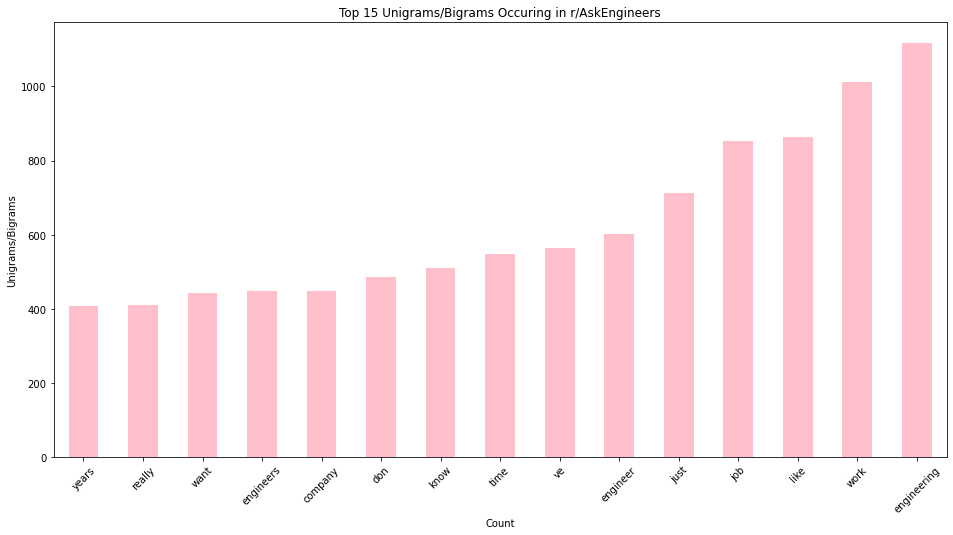

In [101]:
#make comparisoin hbar chart of most common words in both subreddits/ did they have overlap? 
plt.figure(figsize=(16, 8))
engineers_vectorized_df.sum().sort_values(ascending = True).tail(15).plot.bar(color = 'pink');
plt.xlabel('Count')
plt.ylabel('Unigrams/Bigrams')
plt.xticks(rotation = 45)
plt.title('Top 15 Unigrams/Bigrams Occuring in r/AskEngineers')
plt.savefig('../visualizations/ae_top15.png', dpi = 300, bbox_inches = 'tight')

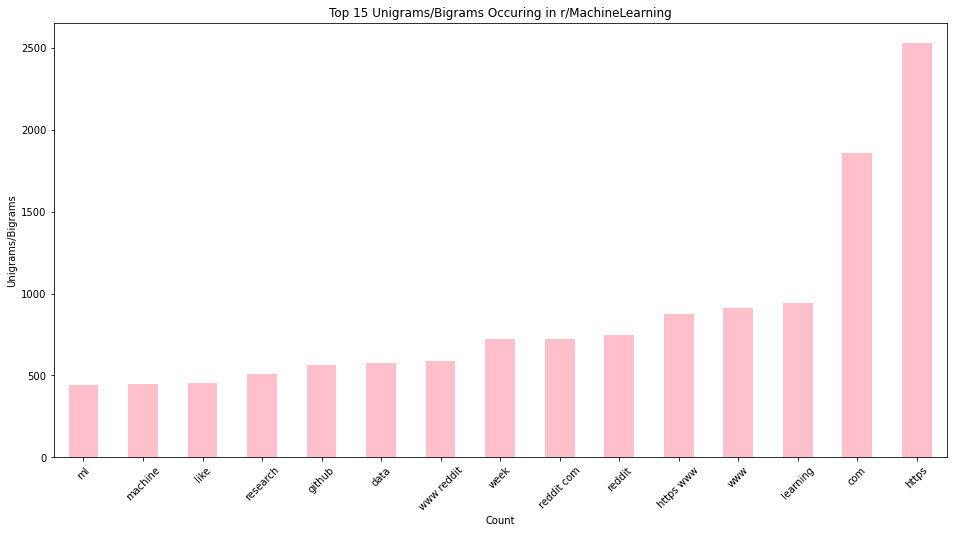

In [102]:
plt.figure(figsize=(16, 8))
ml_vectorized_df.sum().sort_values(ascending = True).tail(15).plot.bar(color = 'pink');
plt.xlabel('Count')
plt.ylabel('Unigrams/Bigrams')
plt.xticks(rotation = 45)
plt.title('Top 15 Unigrams/Bigrams Occuring in r/MachineLearning')
plt.savefig('../visualizations/ml_top15.png', dpi = 300, bbox_inches = 'tight')

In [33]:
#Looking for common words

ae = engineers_vectorized_df.sum().sort_values(ascending = True).tail(25).index
ml = ml_vectorized_df.sum().sort_values(ascending = True).tail(25).index

common = [x for x in ae if x in ml]
common

['like']

In [ ]:
common_25 = ['like']
common_50 = ['com',
 'https',
 'use',
 'new',
 'people',
 'think',
 'know',
 'time',
 've',
 'just',
 'like',
 'work']